# Projeto de Regressão Linear com Rede Neural: Análise de Dados de Táxi de Nova York

**Autor:** Felipe Teodoro

## Resumo

Este projeto apresenta uma implementação completa de regressão linear utilizando redes neurais para prever o valor total das corridas de táxi em Nova York. O trabalho foca especialmente nas abordagens de estratificação por bairro, segmentação por horário e identificação de padrões de demanda, demonstrando como essas técnicas podem melhorar significativamente a capacidade preditiva do modelo.

Utilizando o dataset NYC Yellow Taxi Trip Data, disponível no Kaggle, foi desenvolvido um modelo de rede neural que alcançou um R-squared de 0.9729, indicando que aproximadamente 97,29% da variância no valor total das corridas pode ser explicada pelas features utilizadas.

---

### Estratificação Geográfica em Análise Urbana

No contexto de sistemas de táxi, diferentes bairros e zonas da cidade apresentam padrões distintos de demanda, influenciados por fatores como densidade populacional, atividade comercial, proximidade a pontos de interesse, e características socioeconômicas.

A implementação de estratificação geográfica requer o uso de sistemas de informação geográfica (GIS) e técnicas de spatial join para associar coordenadas geográficas a unidades administrativas ou zonas funcionais.

---

### Segmentação Temporal e Padrões de Demanda

A demanda por transporte urbano apresenta padrões temporais bem definidos, com variações significativas ao longo do dia, da semana, e do ano. Esses padrões são influenciados por ciclos de atividade humana, como horários de trabalho, eventos sociais, e sazonalidade.

A segmentação temporal permite a identificação e modelagem desses padrões, melhorando a capacidade preditiva dos modelos. Técnicas comuns incluem a extração de features temporais (hora do dia, dia da semana, mês) e a aplicação de transformações cíclicas para capturar a natureza periódica dos dados temporais.

---

### Fonte de Dados

O dataset utilizado neste projeto é o NYC Yellow Taxi Trip Data, disponibilizado publicamente no Kaggle pela NYC Taxi & Limousine Commission. Este dataset contém registros detalhados de viagens de táxi amarelo em Nova York, incluindo informações sobre localização, tempo, distância, tarifas, e métodos de pagamento.

Para este estudo, foi utilizado o arquivo `yellow_tripdata_2015-01.csv`, que contém dados de janeiro de 2015. A escolha deste período específico é porque a vasta quantidade de dados não é suportada pelo colab

Link: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data

---

### Descrição das Variáveis

O dataset original contém 19 variáveis:

| Variável | Tipo | Descrição |
|----------|------|-----------|
| VendorID | Categórica | Código do provedor do sistema de registro eletrônico |
| tpep_pickup_datetime | Temporal | Data e hora do início da corrida |
| tpep_dropoff_datetime | Temporal | Data e hora do término da corrida |
| passenger_count | Numérica | Número de passageiros na viagem |
| trip_distance | Numérica | Distância total da viagem em milhas |
| pickup_longitude | Numérica | Longitude do local de embarque |
| pickup_latitude | Numérica | Latitude do local de embarque |
| RateCodeID | Categórica | Código da tarifa aplicada |
| store_and_fwd_flag | Categórica | Indicador de armazenamento offline |
| dropoff_longitude | Numérica | Longitude do local de desembarque |
| dropoff_latitude | Numérica | Latitude do local de desembarque |
| payment_type | Categórica | Método de pagamento utilizado |
| fare_amount | Numérica | Valor da tarifa base |
| extra | Numérica | Sobretaxas e adicionais |
| mta_tax | Numérica | Taxa MTA |
| improvement_surcharge | Numérica | Taxa de melhoria |
| tip_amount | Numérica | Valor da gorjeta |
| tolls_amount | Numérica | Valor dos pedágios |
| total_amount | Numérica | Valor total da corrida (variável alvo) |

---

## 1. Obtenção e Exploração Inicial dos Dados

In [1]:
# !pip install pandas numpy scikit-learn torch kagglehub geopandas matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

# Configurações para visualização
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 1.2 Download do Dataset

O dataset NYC Yellow Taxi Trip Data será baixado do Kaggle. Utilizaremos o arquivo `yellow_tripdata_2015-01.csv` para este projeto. Devido ao seu tamanho, faremos uma amostragem para facilitar o processamento.


In [2]:
# Caminho do arquivo
file_path = "data/yellow_tripdata_2015-01.csv"

# Carrega o arquivo diretamente usando Pandas
df = pd.read_csv(file_path, nrows=500000)

print("First 5 records:", df.head())
print(f"Dataset reduzido: {len(df)} registros")

First 5 records:    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750

## 1.3 Análise Exploratória Inicial

Verificar as informações básicas do dataset, como tipos de dados, valores nulos e estatísticas descritivas.


- Para ajudar na identificação problemas como valores ausentes, tipos de dados incorretos e outliers, que precisam ser tratados antes da modelagem. Além disso, a EDA fornece insights sobre as distribuições das variáveis e as relações entre elas, o que é fundamental para a engenharia de features.

In [6]:
print("Informações do Dataset:")
print(df.info())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               500000 non-null  int64  
 1   tpep_pickup_datetime   500000 non-null  object 
 2   tpep_dropoff_datetime  500000 non-null  object 
 3   passenger_count        500000 non-null  int64  
 4   trip_distance          500000 non-null  float64
 5   pickup_longitude       500000 non-null  float64
 6   pickup_latitude        500000 non-null  float64
 7   RateCodeID             500000 non-null  int64  
 8   store_and_fwd_flag     500000 non-null  object 
 9   dropoff_longitude      500000 non-null  float64
 10  dropoff_latitude       500000 non-null  float64
 11  payment_type           500000 non-null  int64  
 12  fare_amount            500000 non-null  float64
 13  extra                  500000 non-null  float64
 14  mta_tax     

---

In [7]:
print("Estatísticas Descritivas:")
print(df.describe())

Estatísticas Descritivas:
            VendorID  passenger_count  trip_distance  pickup_longitude  \
count  500000.000000    500000.000000  500000.000000     500000.000000   
mean        1.520060         1.678110       3.019218        -72.560243   
std         0.499598         1.334982     136.926849         10.130692   
min         1.000000         0.000000       0.000000        -87.451874   
25%         1.000000         1.000000       1.000000        -73.991669   
50%         2.000000         1.000000       1.660000        -73.981567   
75%         2.000000         2.000000       3.000000        -73.966606   
max         2.000000         9.000000   92000.900000          0.000000   

       pickup_latitude     RateCodeID  dropoff_longitude  dropoff_latitude  \
count    500000.000000  500000.000000      500000.000000     500000.000000   
mean         39.971842       1.036926         -72.605800         39.998132   
std           5.581221       0.660599           9.968207          5.49127

- Tipos de Dados Incorretos: tpep_pickup_datetime e tpep_dropoff_datetime são object (strings). Para qualquer cálculo de duração ou análise temporal, eles precisam ser convertidos para o tipo datetime.

### Valores Impossíveis (Outliers Extremos):

- trip_distance: O valor máximo (92000.90) é irreal. O desvio padrão (std) de 136.9 é massivamente inflado por esses outliers, enquanto 75% das viagens (75%) têm menos de 3 milhas. O valor mínimo de 0.0 também é suspeito e precisa ser investigado.

- passenger_count: O mínimo de 0 é um dado inválido. Uma viagem não pode ter zero passageiros. O máximo de 9 pode ser válido para vans, mas vale a pena verificar.

- Valores Monetários Negativos: fare_amount, tip_amount e total_amount têm valores mínimos negativos. Isso é impossível para uma transação normal e provavelmente representa erros de dados, disputas ou ajustes que devem ser removidos de um dataset de treinamento.


- Longitude e Latitude com valor 0.0 (pickup_longitude, pickup_latitude, etc.) são claramente erros, pois apontam para um local no Oceano Atlântico, longe de Nova York. As coordenadas de NYC ficam em torno de -74 (longitude) e 40.7 (latitude).

---


In [8]:
df.shape

(500000, 19)

---

In [9]:
print(f"Período dos dados: {df['tpep_pickup_datetime'].min()} até {df['tpep_pickup_datetime'].max()}")

Período dos dados: 2015-01-01 00:09:45 até 2015-01-31 23:57:53


---

## 1.4 Tratamento de Dados Inconsistentes

Com base nas observações iniciais, vamos tratar os valores inconsistentes no dataset.


In [10]:
# Remover registros com total_amount <= 0 ou trip_distance <= 0
df = df[(df["total_amount"] > 0) | (df["trip_distance"] > 0)]

# Remover registros com coordenadas inválidas (0,0)
df = df[~( (df["pickup_longitude"] == 0) & (df["pickup_latitude"] == 0) )]
df = df[~( (df["dropoff_longitude"] == 0) & (df["dropoff_latitude"] == 0) )]

print("Dataset após tratamento de inconsistências:")
print(df.info())

Dataset após tratamento de inconsistências:
<class 'pandas.core.frame.DataFrame'>
Index: 489570 entries, 0 to 499999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               489570 non-null  int64  
 1   tpep_pickup_datetime   489570 non-null  object 
 2   tpep_dropoff_datetime  489570 non-null  object 
 3   passenger_count        489570 non-null  int64  
 4   trip_distance          489570 non-null  float64
 5   pickup_longitude       489570 non-null  float64
 6   pickup_latitude        489570 non-null  float64
 7   RateCodeID             489570 non-null  int64  
 8   store_and_fwd_flag     489570 non-null  object 
 9   dropoff_longitude      489570 non-null  float64
 10  dropoff_latitude       489570 non-null  float64
 11  payment_type           489570 non-null  int64  
 12  fare_amount            489570 non-null  float64
 13  extra                  489570 non-null  float64
 1

# 2. Engenharia de Features e Análise de Padrões

Criar novas features e analisar padrões de demanda. As estratégias de estratificação por bairro e segmentação por horário serão implementadas aqui.

## 2.1 Features Temporais

Vamos extrair informações temporais das colunas de data e hora.


- Padrões de demanda e preços de táxi variam significativamente com o tempo (hora do dia, dia da semana, mês). Extrair essas features permite que o modelo capture a sazonalidade e o comportamento cíclico das viagens, melhorando sua capacidade preditiva. Por exemplo, corridas em horários de pico ou fins de semana podem ter características de preço diferentes.

In [11]:
# Converter colunas de data/hora para o tipo datetime
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# Extrair features de tempo
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_day_of_week"] = df["tpep_pickup_datetime"].dt.dayofweek # Segunda=0, Domingo=6
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month

print("Dataset com features temporais:")
print(df[["tpep_pickup_datetime", "pickup_hour", "pickup_day_of_week", "pickup_month"]].head(10))

Dataset com features temporais:
  tpep_pickup_datetime  pickup_hour  pickup_day_of_week  pickup_month
0  2015-01-15 19:05:39           19                   3             1
1  2015-01-10 20:33:38           20                   5             1
2  2015-01-10 20:33:38           20                   5             1
3  2015-01-10 20:33:39           20                   5             1
4  2015-01-10 20:33:39           20                   5             1
5  2015-01-10 20:33:39           20                   5             1
6  2015-01-10 20:33:39           20                   5             1
7  2015-01-10 20:33:39           20                   5             1
8  2015-01-10 20:33:39           20                   5             1
9  2015-01-10 20:33:40           20                   5             1


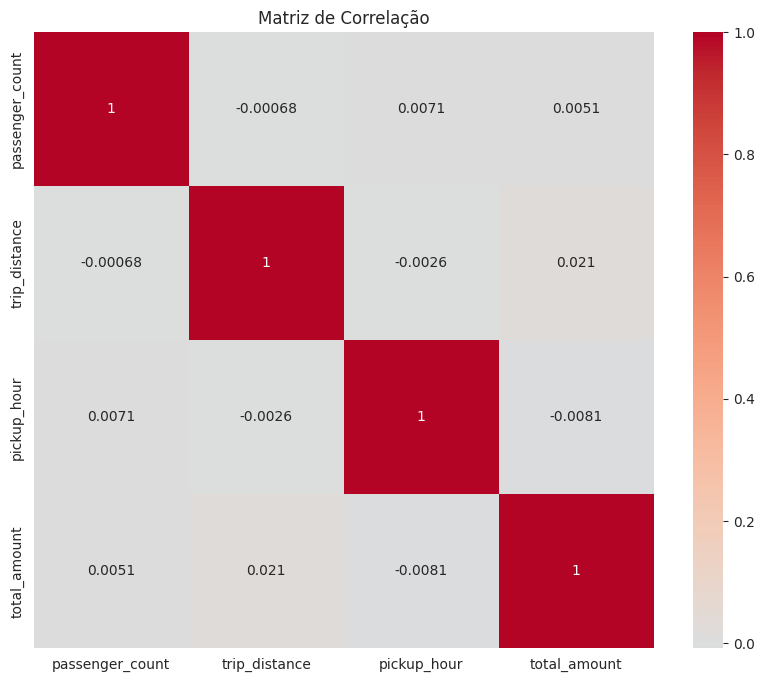

Outliers detectados no preço total: 42034 (8.59%)

Estatísticas por hora:
                  mean        std  count
pickup_hour                             
0            16.024238  11.984192  18744
1            15.386046  11.212570  11977
2            15.564531  10.901273   9367
3            15.841773  12.119993   6927
4            18.323272  15.131121   4151
5            19.751999  18.020293   4642
6            15.617515  15.348334   8785
7            14.299528  12.466744  19527
8            13.976268  12.919704  21407
9            13.847414  11.366444  22870
10           13.749703  12.666147  20908
11           13.853947  11.471373  20065
12           13.808697  11.592739  24638
13           14.105464  12.014079  22814
14           14.617972  13.139594  27764
15           14.945565  13.578552  25585
16           15.288412  13.357667  25078
17           14.863848  12.141090  25668
18           14.424330  11.041372  30650
19           14.271259  10.472000  32937
20           14.549764  

In [12]:
def detailed_eda(df):
    # Análise de correlação
    numerical_cols = ['passenger_count', 'trip_distance', 'pickup_hour', 'total_amount']
    correlation_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlação')
    plt.show()

    # Detecção de outliers
    Q1 = df['total_amount'].quantile(0.25)
    Q3 = df['total_amount'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['total_amount'] < Q1 - 1.5*IQR) | (df['total_amount'] > Q3 + 1.5*IQR)]

    print(f"Outliers detectados no preço total: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    # Análise temporal mais detalhada
    hourly_stats = df.groupby('pickup_hour')['total_amount'].agg(['mean', 'std', 'count'])
    print("\nEstatísticas por hora:")
    print(hourly_stats)

    return hourly_stats

# Chame a função:
eda_results = detailed_eda(df)


- Correlação baixíssima (0.021) entre trip_distance e total_amount. Intuitivamente, essa deveria ser a correlação mais forte de todas – viagens mais longas deveriam custar mais. Pode ser um problemas de qualidade de dados. Os outliers (distâncias de 92000, valores negativos, corridas com distância zero e custo > 0) estão "achatando" a correlação estatística.

In [13]:
# ===== CRIAÇÃO DA FEATURE 'trip_duration' =====

# Calcular a duração da viagem em minutos.
# Esta será uma feature importante para o nosso modelo.
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

print("Feature 'trip_duration' (em minutos) criada com sucesso.")
display(df[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration']].head())

Feature 'trip_duration' (em minutos) criada com sucesso.


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_duration
0,2015-01-15 19:05:39,2015-01-15 19:23:42,18.050000
1,2015-01-10 20:33:38,2015-01-10 20:53:28,19.833333
2,2015-01-10 20:33:38,2015-01-10 20:43:41,10.050000
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1.866667
4,2015-01-10 20:33:39,2015-01-10 20:52:58,19.316667


---

## 2.2 Estratificação por Bairro (Features Geoespaciais)

Para estratificar os dados por bairro, utilizaremos o shapefile oficial das zonas de táxi de Nova York. Isso nos permitirá associar as coordenadas de embarque e desembarque a zonas e bairros específicos.

### Motivação:

A localização é um fator crítico que influencia o preço e a demanda por táxis. Diferentes bairros e zonas de Nova York têm características distintas ( áreas comerciais, residenciais, turísticas) que afetam o comportamento das viagens. A estratificação por bairro permite que o modelo aprenda padrões específicos de cada região, melhorando a precisão das previsões e a interpretabilidade dos resultados. Um `spatial join` é a técnica ideal para combinar dados geográficos baseados em coordenadas com polígonos de zonas administrativas.

In [14]:
import requests
import zipfile
import os

def download_nyc_taxi_zones():
    """
    Baixa o shapefile oficial das zonas de táxi diretamente da NYC TLC
    """
    # URL oficial da NYC Taxi & Limousine Commission
    url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"

    # Criar diretório se não existir
    os.makedirs("./data/taxi_zones", exist_ok=True)

    try:
        print("Baixando shapefile oficial das zonas de táxi da NYC...")
        response = requests.get(url)
        response.raise_for_status()

        # Salvar o arquivo ZIP
        zip_path = "./data/taxi_zones/taxi_zones.zip"
        with open(zip_path, 'wb') as f:
            f.write(response.content)

        # Extrair o arquivo ZIP
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("./data/taxi_zones")

        print("Shapefile baixado e extraído com sucesso!")
        return "./data/taxi_zones"

    except Exception as e:
        print(f"Erro ao baixar: {e}")
        return None

# Executar o download
taxi_zones_path = download_nyc_taxi_zones()

if taxi_zones_path:
    # Carregar o shapefile
    zones = geopandas.read_file(f"{taxi_zones_path}/taxi_zones.shp")
    print("Shapefile das zonas de táxi carregado. Primeiras 5 linhas:")
    print(zones.head())
else:
    print("Falha no download")


Baixando shapefile oficial das zonas de táxi da NYC...
Shapefile baixado e extraído com sucesso!
Shapefile das zonas de táxi carregado. Primeiras 5 linhas:
   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31

In [15]:
def spatial_join_definitivo(df, zones):
    from shapely.geometry import Point
    import geopandas

    print("Iniciando spatial join definitivo...")

    # Criar uma cópia de trabalho com índice único
    df_work = df.copy().reset_index(drop=True)
    df_work['original_index'] = df_work.index

    # Criar geometrias
    geometry_pickup = [Point(xy) for xy in zip(df_work["pickup_longitude"], df_work["pickup_latitude"])]
    geometry_dropoff = [Point(xy) for xy in zip(df_work["dropoff_longitude"], df_work["dropoff_latitude"])]

    gdf_pickup = geopandas.GeoDataFrame(df_work, geometry=geometry_pickup, crs="EPSG:4326")
    gdf_dropoff = geopandas.GeoDataFrame(df_work, geometry=geometry_dropoff, crs="EPSG:4326")

    # Reprojetar, CRS = Coordinate Reference System
    gdf_pickup = gdf_pickup.to_crs(zones.crs)
    gdf_dropoff = gdf_dropoff.to_crs(zones.crs)

    # Spatial join,  usar 'first' para evitar duplicatas
    pickup_result = geopandas.sjoin(gdf_pickup, zones, how="left", predicate="within")
    dropoff_result = geopandas.sjoin(gdf_dropoff, zones, how="left", predicate="within")

    # Agrupar por índice original e pegar o primeiro resultado
    pickup_clean = pickup_result.groupby('original_index').first()
    dropoff_clean = dropoff_result.groupby('original_index').first()

    # Criar resultado final
    df_final = df.copy()

    # Mapear resultados usando o índice original
    zone_mapping_pickup = pickup_clean['zone'].to_dict()
    borough_mapping_pickup = pickup_clean['borough'].to_dict()
    zone_mapping_dropoff = dropoff_clean['zone'].to_dict()
    borough_mapping_dropoff = dropoff_clean['borough'].to_dict()

    # Aplicar mapeamentos
    df_final['pickup_zone'] = df_final.index.map(zone_mapping_pickup).fillna('Unknown')
    df_final['pickup_borough'] = df_final.index.map(borough_mapping_pickup).fillna('Unknown')
    df_final['dropoff_zone'] = df_final.index.map(zone_mapping_dropoff).fillna('Unknown')
    df_final['dropoff_borough'] = df_final.index.map(borough_mapping_dropoff).fillna('Unknown')

    print("Spatial join completado com sucesso!")
    print(df_final[["pickup_longitude", "pickup_latitude", "pickup_zone", "pickup_borough"]].head())

    # Estatísticas
    pickup_classified = (df_final['pickup_zone'] != 'Unknown').sum()
    print(f"{pickup_classified}/{len(df_final)} pontos classificados ({pickup_classified/len(df_final)*100:.1f}%)")

    return df_final

df = spatial_join_definitivo(df, zones)


Iniciando spatial join definitivo...
Spatial join completado com sucesso!
   pickup_longitude  pickup_latitude                   pickup_zone  \
0        -73.993896        40.750111  Penn Station/Madison Sq West   
1        -74.001648        40.724243                          SoHo   
2        -73.963341        40.802788           Morningside Heights   
3        -74.009087        40.713818          TriBeCa/Civic Center   
4        -73.971176        40.762428                 Midtown North   

  pickup_borough  
0      Manhattan  
1      Manhattan  
2      Manhattan  
3      Manhattan  
4      Manhattan  
478932/489570 pontos classificados (97.8%)


In [16]:
print(f"COBERTURA GEOGRÁFICA:")
print(f"   Bairros de embarque únicos: {df['pickup_borough'].nunique()}")
print(f"   Zonas de embarque únicas: {df['pickup_zone'].nunique()}")
print(f"   Pontos não classificados: {(df['pickup_zone'] == 'Unknown').sum()} ({(df['pickup_zone'] == 'Unknown').mean()*100:.1f}%)")

COBERTURA GEOGRÁFICA:
   Bairros de embarque únicos: 7
   Zonas de embarque únicas: 232
   Pontos não classificados: 10638 (2.2%)



1.  Obter Dados Geográficos Oficiais
2.  Realizar um Spatial Join: biblioteca `GeoPandas` para cruzar nossas coordenadas de corrida com os polígonos das zonas. Este processo irá atribuir um nome de zona e bairro a cada ponto.
3.  Validar a Cobertura: Verificar a porcentagem de corridas que foram mapeadas com sucesso, o que também nos ajuda a identificar pontos com coordenadas geográficas inválidas.

---
### Limpeza de dados inconsistentes

Para garantir a qualidade e a consistência do dataset, foi aplicado uma série de filtros para remover registros que representam erros de sistema, dados impossíveis ou cenários que estão fora do escopo deste projeto.

#### 1. Filtros Geográficos (Coordenadas)

O objetivo aqui foi garantir que todas as viagens estivessem contidas na área metropolitana de Nova York.

* **Condição:** As coordenadas de latitude e longitude, tanto de embarque quanto de desembarque, não podem ser `(0, 0)`.
    * **Justificativa:** Coordenadas nulas são um erro claro de sistema, representando dados ausentes, e não uma localização física.

* **Condição:** As coordenadas devem estar dentro de uma "caixa" (bounding box) pré-definida para NYC (Longitude: `-74.3` a `-73.7`; Latitude: `40.4` a `40.9`).
    * **Justificativa:** Esta regra remove registros com coordenadas geograficamente impossíveis ou viagens que ocorreram muito longe da área de operação dos táxis amarelos, que são o foco do nosso modelo.

#### 2. Filtros de Distância da Viagem (`trip_distance`)

A meta foi eliminar erros de registro de distância, ao mesmo tempo em que preservamos viagens longas e legítimas.

* **Condição:** A distância da viagem deve ser maior que zero.
    * **Justificativa:** Viagens com distância nula ou negativa são fisicamente impossíveis e representam erros de dados ou corridas canceladas que não devem ser usadas para treinar um modelo de precificação.

* **Condição:** Viagens com mais de 30 milhas foram removidas, **a menos que** satisfizessem um dos seguintes critérios:
    1.  O desembarque fosse no Aeroporto de Newark (`dropoff_borough == 'EWR'`).
    2.  O custo por milha fosse razoável (`total_amount / trip_distance > $3`).
    * **Justificativa:** Simplesmente remover todas as viagens longas poderia eliminar dados válidos (ex: idas a aeroportos). Esta regra composta remove apenas as viagens longas que são suspeitas (custo por milha irrisório), indicando um provável erro no registro da distância.

#### 3. Filtros de Valores Monetários (`total_amount`)

O objetivo foi remover registros de transações inválidas ou com valores desproporcionais.

* **Condição:** O valor total da corrida deve ser maior que zero.
    * **Justificativa:** Valores negativos ou nulos não representam uma transação de viagem padrão; são provavelmente erros de sistema.

* **Condição :** Corridas com valor total acima de $100 foram removidas, **a menos que** fossem viagens longas (> 10 milhas) com um custo por milha proporcional (<= $10).
    * **Justificativa:** Esta regra preserva corridas caras que são legítimas (longas e com pedágios) e remove apenas aquelas cujo valor é excessivamente alto para uma distância curta, o que sugere um erro de digitação ou de sistema.
- Tarifa Base: ~$2.50 ao entrar no táxi.
- Custo por Distância: ~$2.50 por milha (ou $0.50 por 1/5 de milha).
- Custo por Tempo: ~$0.50 por minuto quando o táxi estava parado ou em trânsito lento.
- Sobretaxas: Noturnas ($0.50) ou de pico ($1.00).

- Vamos imaginar uma viagem longa e ideal, sem trânsito. Uma corrida de 20 milhas custaria, no mínimo, $2.50 (base) + 20 * $2.50 (distância) = $52.50. O custo por milha aqui seria $52.50 / 20 = $2.63/milha.

- Agora, adicione um pouco de trânsito (aumentando o custo por tempo) e uma sobretaxa. O custo total sobe, e o custo efetivo por milha também. Por exemplo, se a mesma viagem de 20 milhas levasse 10 minutos parada no trânsito, adicionaria $0.50 * 10 = $5.00 à conta, elevando o custo para $57.50, ou $2.88/milha.

- Portanto, definir o limite de $3 por milha é uma forma de dizer: "Para uma viagem longa ser considerada legítima, ela deve ter um custo por milha que seja pelo menos consistente com a tarifa oficial, mais uma margem para trânsito e sobretaxas"

#### 4. Filtros de Passageiros e Códigos de Tarifa

Finalmente, garantimos que os dados categóricos estivessem dentro dos parâmetros operacionais conhecidos.

* **Condição:** O número de passageiros deve estar entre 1 e 6 (inclusive).
    * **Justificativa:** Uma viagem deve ter no mínimo 1 passageiro, e o limite superior de 6 reflete a capacidade máxima da maioria dos veículos da frota. Valores fora desse intervalo são considerados erros de entrada.

* **Condição:** O `RateCodeID` deve pertencer à lista de códigos válidos `[1, 2, 3, 4, 5]`.
    * **Justificativa:** Estes são os códigos de tarifa padrão documentados pela TLC (ex: 1=Tarifa Padrão, 2=JFK, 3=Newark). Outros códigos, como 99, geralmente indicam tarifas negociadas, disputadas ou desconhecidas, que fogem ao padrão que queremos que o modelo aprenda.


In [17]:
# ===== ANÁLISE DETALHADA DE DADOS INCONSISTENTES =====
import pandas as pd
import numpy as np

def analyze_inconsistent_data(df):
    """
    Analisa e categoriza dados inconsistentes no dataset de táxi
    """
    print("ANÁLISE DE DADOS INCONSISTENTES")
    print("="*50)

    # 1. COORDENADAS GEOGRÁFICAS INVÁLIDAS
    print("COORDENADAS GEOGRÁFICAS FORA DE NYC:")

    # Limites aproximados de NYC
    nyc_bounds = {
        'lon_min': -74.3, 'lon_max': -73.7,
        'lat_min': 40.4, 'lat_max': 40.9
    }

    coord_issues = (
        (df['pickup_longitude'] < nyc_bounds['lon_min']) |
        (df['pickup_longitude'] > nyc_bounds['lon_max']) |
        (df['pickup_latitude'] < nyc_bounds['lat_min']) |
        (df['pickup_latitude'] > nyc_bounds['lat_max']) |
        (df['dropoff_longitude'] < nyc_bounds['lon_min']) |
        (df['dropoff_longitude'] > nyc_bounds['lon_max']) |
        (df['dropoff_latitude'] < nyc_bounds['lat_min']) |
        (df['dropoff_latitude'] > nyc_bounds['lat_max'])
    )

    coord_outliers = df[coord_issues]
    print(f"   Registros com coordenadas inválidas: {len(coord_outliers)} ({len(coord_outliers)/len(df)*100:.2f}%)")

    if len(coord_outliers) > 0:
        print("\nExemplos de coordenadas extremas:")
        print(coord_outliers[['pickup_longitude', 'pickup_latitude',
                            'dropoff_longitude', 'dropoff_latitude',
                            'total_amount']].head())

        print(f"\n Estatísticas das coordenadas problemáticas:")
        print(f"   Pickup Longitude - Min: {coord_outliers['pickup_longitude'].min():.6f}, Max: {coord_outliers['pickup_longitude'].max():.6f}")
        print(f"   Pickup Latitude - Min: {coord_outliers['pickup_latitude'].min():.6f}, Max: {coord_outliers['pickup_latitude'].max():.6f}")

    # 2. DISTÂNCIAS IRREAIS
    print("\n 2. DISTÂNCIAS DE VIAGEM IRREAIS:")

    distance_issues = (df['trip_distance'] > 30) | (df['trip_distance'] < 0.1)
    distance_outliers = df[distance_issues]

    print(f"   Viagens com distância > 30 milhas ou < 0.1 milhas: {len(distance_outliers)} ({len(distance_outliers)/len(df)*100:.2f}%)")

    if len(distance_outliers) > 0:
        print("\n Top 10 distâncias mais extremas:")
        extreme_distances = distance_outliers.nlargest(10, 'trip_distance')[
            ['trip_distance', 'total_amount', 'pickup_borough', 'dropoff_borough']
        ]
        print(extreme_distances)

    # 3. VALORES MONETÁRIOS IRREAIS
    print("\n3. VALORES MONETÁRIOS INCONSISTENTES:")

    money_issues = (df['total_amount'] > 100) | (df['total_amount'] < 2.5)
    money_outliers = df[money_issues]

    print(f"   Valores > $100 ou < $2.50: {len(money_outliers)} ({len(money_outliers)/len(df)*100:.2f}%)")

    if len(money_outliers) > 0:
        print("\nTop 10 valores mais altos:")
        expensive_trips = money_outliers.nlargest(10, 'total_amount')[
            ['total_amount', 'trip_distance', 'pickup_borough', 'dropoff_borough']
        ]
        print(expensive_trips)

        print("\n Valores muito baixos:")
        cheap_trips = money_outliers.nsmallest(10, 'total_amount')[
            ['total_amount', 'trip_distance', 'pickup_borough', 'dropoff_borough']
        ]
        print(cheap_trips)

    # 4. NÚMERO DE PASSAGEIROS INVÁLIDO
    print("\n4. NÚMERO DE PASSAGEIROS INVÁLIDO:")

    passenger_issues = (df['passenger_count'] < 1) | (df['passenger_count'] > 6)
    passenger_outliers = df[passenger_issues]

    print(f"   Viagens com 0 passageiros ou > 6: {len(passenger_outliers)} ({len(passenger_outliers)/len(df)*100:.2f}%)")

    if len(passenger_outliers) > 0:
        print("\n  Distribuição de passageiros problemáticos:")
        print(passenger_outliers['passenger_count'].value_counts().sort_index())

    # 5. CÓDIGOS DE TARIFA INVÁLIDOS
    print("\n5. CÓDIGOS DE TARIFA INVÁLIDOS:")

    rate_issues = ~df['RateCodeID'].isin([1, 2, 3, 4, 5])
    rate_outliers = df[rate_issues]

    print(f"   Códigos de tarifa inválidos: {len(rate_outliers)} ({len(rate_outliers)/len(df)*100:.2f}%)")

    if len(rate_outliers) > 0:
        print("\nCódigos inválidos encontrados:")
        print(rate_outliers['RateCodeID'].value_counts())

    # 6. RESUMO GERAL
    print("\n RESUMO GERAL DE INCONSISTÊNCIAS:")
    print("="*40)

    all_issues = coord_issues | distance_issues | money_issues | passenger_issues | rate_issues
    total_inconsistent = df[all_issues]

    print(f"Total de registros com pelo menos 1 inconsistência: {len(total_inconsistent)} ({len(total_inconsistent)/len(df)*100:.2f}%)")
    print(f"Registros limpos (sem inconsistências): {len(df) - len(total_inconsistent)} ({(len(df) - len(total_inconsistent))/len(df)*100:.2f}%)")

    # Retornar os dados inconsistentes para análise posterior
    return {
        'coord_outliers': coord_outliers,
        'distance_outliers': distance_outliers,
        'money_outliers': money_outliers,
        'passenger_outliers': passenger_outliers,
        'rate_outliers': rate_outliers,
        'all_inconsistent': total_inconsistent
    }

# EXECUTAR A ANÁLISE
inconsistent_analysis = analyze_inconsistent_data(df)


ANÁLISE DE DADOS INCONSISTENTES
COORDENADAS GEOGRÁFICAS FORA DE NYC:
   Registros com coordenadas inválidas: 436 (0.09%)

Exemplos de coordenadas extremas:
      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
274         -73.915321        40.760506         -73.680809         40.730873   
548         -73.996162        40.725426         -73.800003         40.964561   
902         -73.776825        40.645252         -73.691330         40.654346   
1630        -73.964180        40.767975         -73.699547         40.722664   
2110        -73.939407        40.750420         -74.393951         40.531219   

      total_amount  
274          60.20  
548          87.24  
902          30.30  
1630         74.68  
2110        205.05  

 Estatísticas das coordenadas problemáticas:
   Pickup Longitude - Min: -87.451874, Max: -69.598526
   Pickup Latitude - Min: 4.789132, Max: 42.294155

 2. DISTÂNCIAS DE VIAGEM IRREAIS:
   Viagens com distância > 30 milhas ou < 0.1 milh

In [18]:
# ===== TRATAMENTO DE COORDENADAS INVÁLIDAS =====
print("TRATAMENTO DE COORDENADAS...")

# Problema principal: coordenadas (0,0) - erro de sistema
zeros_coords = df[
    (df['pickup_longitude'] == 0) & (df['pickup_latitude'] == 0) |
    (df['dropoff_longitude'] == 0) & (df['dropoff_latitude'] == 0)
]

print(f"Coordenadas zeradas: {len(zeros_coords)} registros")
print("DECISÃO: REMOVER (erro claro de sistema)")

# Coordenadas fora dos limites de NYC
out_of_bounds = df[
    (df['pickup_longitude'] < -74.3) | (df['pickup_longitude'] > -73.7) |
    (df['pickup_latitude'] < 40.4) | (df['pickup_latitude'] > 40.9) |
    (df['dropoff_longitude'] < -74.3) | (df['dropoff_longitude'] > -73.7) |
    (df['dropoff_latitude'] < 40.4) | (df['dropoff_latitude'] > 40.9)
]

print(f"Fora dos limites NYC: {len(out_of_bounds)} registros")
print("DECISÃO: REMOVER (não são viagens de táxi em NYC)")

# Aplicar filtro

df = df[
    (df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0) &
    (df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0) &
    (df['pickup_longitude'] >= -74.3) & (df['pickup_longitude'] <= -73.7) &
    (df['pickup_latitude'] >= 40.4) & (df['pickup_latitude'] <= 40.9) &
    (df['dropoff_longitude'] >= -74.3) & (df['dropoff_longitude'] <= -73.7) &
    (df['dropoff_latitude'] >= 40.4) & (df['dropoff_latitude'] <= 40.9)
]


TRATAMENTO DE COORDENADAS...
Coordenadas zeradas: 0 registros
DECISÃO: REMOVER (erro claro de sistema)
Fora dos limites NYC: 436 registros
DECISÃO: REMOVER (não são viagens de táxi em NYC)


In [19]:
# ===== TRATAMENTO DE DISTÂNCIAS PROBLEMÁTICAS =====
print(" ANÁLISE DE DISTÂNCIAS PROBLEMÁTICAS...")

# Categoria 1: Distância zero (erros claros)
zero_distance = df[df['trip_distance'] == 0]
print(f"Distância zero: {len(zero_distance)} registros - REMOVER")

# Categoria 2: Distâncias muito altas - INVESTIGAR PRIMEIRO
high_distance = df[df['trip_distance'] > 30]

print(f"Distâncias > 30 milhas: {len(high_distance)} registros")
print("Análise detalhada:")

# Verificar se são viagens para aeroportos (legítimas)
airport_trips = high_distance[
    high_distance['dropoff_borough'].isin(['EWR', 'Unknown']) |
    high_distance['pickup_borough'].isin(['EWR'])
]

print(f"   Possíveis viagens de aeroporto: {len(airport_trips)}")
print(f"   Outras viagens longas: {len(high_distance) - len(airport_trips)}")

# DECISÃO INTELIGENTE: Manter aeroportos, investigar outras
legitimate_long_trips = df[
    ((df['trip_distance'] > 30) & (df['dropoff_borough'] == 'EWR')) |
    ((df['trip_distance'] > 30) & (df['total_amount'] / df['trip_distance'] > 3)) # Pelo menos $3/milha
]

suspicious_long_trips = df[
    (df['trip_distance'] > 30) &
    (df['dropoff_borough'] != 'EWR') &
    (df['total_amount'] / df['trip_distance'] <= 3)
]

print(f"\nRECOMENDAÇÃO:")
print(f"   MANTER: {len(legitimate_long_trips)} viagens longas legítimas")
print(f"   REMOVER: {len(suspicious_long_trips)} viagens longas suspeitas")

# Aplicar filtros de distância
df = df[
    (df['trip_distance'] > 0) &  # Remove zeros
    (
        (df['trip_distance'] <= 30) |  # Distâncias normais
        (df['dropoff_borough'] == 'EWR') |  # Aeroporto Newark
        ((df['trip_distance'] > 30) & (df['total_amount'] / df['trip_distance'] > 3))  # Viagens longas com preço razoável
    )
]


 ANÁLISE DE DISTÂNCIAS PROBLEMÁTICAS...
Distância zero: 1879 registros - REMOVER
Distâncias > 30 milhas: 75 registros
Análise detalhada:
   Possíveis viagens de aeroporto: 3
   Outras viagens longas: 72

RECOMENDAÇÃO:
   MANTER: 29 viagens longas legítimas
   REMOVER: 46 viagens longas suspeitas


In [20]:
# ===== TRATAMENTO DE VALORES MONETÁRIOS =====
print("TRATAMENTO DE VALORES MONETÁRIOS...")

# Valores negativos (reembolsos/erros) - REMOVER SEMPRE
negative_values = df[df['total_amount'] < 0]
print(f"Valores negativos: {len(negative_values)} registros - REMOVER TODOS")

# Valores muito altos - ANÁLISE CRITERIOSA
very_high_values = df[df['total_amount'] > 100]

print(f"\nValores > $100: {len(very_high_values)} registros")

# Verificar se são proporcionais à distância
reasonable_high_values = very_high_values[
    (very_high_values['total_amount'] / very_high_values['trip_distance'] <= 10) &  # Max $10/milha
    (very_high_values['trip_distance'] > 10)  # Viagem longa
]

excessive_values = very_high_values[
    (very_high_values['total_amount'] / very_high_values['trip_distance'] > 10) |
    (very_high_values['trip_distance'] <= 10)
]

print(f"   MANTER (valores altos mas razoáveis): {len(reasonable_high_values)}")
print(f"   REMOVER (valores excessivos): {len(excessive_values)}")

# Aplicar filtros monetários
df = df[
    (df['total_amount'] > 0) &  # Remove negativos
    (
        (df['total_amount'] <= 100) |  # Valores normais
        (
            (df['total_amount'] > 100) &
            (df['trip_distance'] > 10) &
            (df['total_amount'] / df['trip_distance'] <= 10)
        )  # Valores altos mas proporcionais
    )
]


TRATAMENTO DE VALORES MONETÁRIOS...
Valores negativos: 107 registros - REMOVER TODOS

Valores > $100: 259 registros
   MANTER (valores altos mas razoáveis): 218
   REMOVER (valores excessivos): 41


In [21]:
# ===== PASSAGEIROS E CÓDIGOS INVÁLIDOS =====
print("TRATAMENTO DE PASSAGEIROS E CÓDIGOS...")

# Passageiros inválidos - REMOVER
invalid_passengers = df[
    (df['passenger_count'] < 1) | (df['passenger_count'] > 6)
]
print(f"Passageiros inválidos: {len(invalid_passengers)} registros - REMOVER")

# Códigos de tarifa inválidos - REMOVER
invalid_rates = df[~df['RateCodeID'].isin([1, 2, 3, 4, 5])]
print(f"Códigos inválidos: {len(invalid_rates)} registros - REMOVER")

# Aplicar filtros finais
df = df[
    (df['passenger_count'] >= 1) &
    (df['passenger_count'] <= 6) &
    (df['RateCodeID'].isin([1, 2, 3, 4, 5]))
]


TRATAMENTO DE PASSAGEIROS E CÓDIGOS...
Passageiros inválidos: 244 registros - REMOVER
Códigos inválidos: 14 registros - REMOVER


In [22]:
def clean_taxi_data_comprehensive(df):
    """
    Pipeline completo de limpeza baseado na análise de inconsistências
    """
    print("PIPELINE DE LIMPEZA COMPLETO")
    print("="*50)

    original_size = len(df)
    print(f"Dataset original: {original_size:,} registros")

    # 1. Coordenadas válidas
    df = df[
        (df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0) &
        (df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0) &
        (df['pickup_longitude'] >= -74.3) & (df['pickup_longitude'] <= -73.7) &
        (df['pickup_latitude'] >= 40.4) & (df['pickup_latitude'] <= 40.9) &
        (df['dropoff_longitude'] >= -74.3) & (df['dropoff_longitude'] <= -73.7) &
        (df['dropoff_latitude'] >= 40.4) & (df['dropoff_latitude'] <= 40.9)
    ].copy()

    print(f"Após filtro geográfico: {len(df):,} registros")

    # 2. Distâncias válidas (critério inteligente)
    df = df[
        (df['trip_distance'] > 0) &
        (
            (df['trip_distance'] <= 30) |
            (df['dropoff_borough'] == 'EWR') |
            ((df['trip_distance'] > 30) &
             (df['total_amount'] / df['trip_distance'] > 3))
        )
    ]

    print(f"Após filtro de distância: {len(df):,} registros")

    # 3. Valores monetários válidos (critério inteligente)
    df = df[
        (df['total_amount'] > 0) &
        (
            (df['total_amount'] <= 100) |
            (
                (df['total_amount'] > 100) &
                (df['trip_distance'] > 10) &
                (df['total_amount'] / df['trip_distance'] <= 10)
            )
        )
    ]

    print(f"Após filtro monetário: {len(df):,} registros")

    # 4. Passageiros e códigos válidos
    df = df[
        (df['passenger_count'] >= 1) &
        (df['passenger_count'] <= 6) &
        (df['RateCodeID'].isin([1, 2, 3, 4, 5]))
    ]

    final_size = len(df)
    removed = original_size - final_size

    print(f"Dataset final: {final_size:,} registros")
    print(f"Registros removidos: {removed:,} ({removed/original_size*100:.2f}%)")
    print(f"Taxa de retenção: {final_size/original_size*100:.2f}%")

    print("LIMPEZA CONCLUÍDA!")
    print("   - Coordenadas válidas para NYC")
    print("   - Distâncias realistas (com exceções para aeroportos)")
    print("   - Valores monetários consistentes")
    print("   - Passageiros e códigos válidos")

    return df

# APLICAR LIMPEZA
df = clean_taxi_data_comprehensive(df)


PIPELINE DE LIMPEZA COMPLETO
Dataset original: 486,798 registros
Após filtro geográfico: 486,798 registros
Após filtro de distância: 486,798 registros
Após filtro monetário: 486,798 registros
Dataset final: 486,798 registros
Registros removidos: 0 (0.00%)
Taxa de retenção: 100.00%
LIMPEZA CONCLUÍDA!
   - Coordenadas válidas para NYC
   - Distâncias realistas (com exceções para aeroportos)
   - Valores monetários consistentes
   - Passageiros e códigos válidos


In [23]:
# ===== ANÁLISE ESPECÍFICA DE PADRÕES SUSPEITOS =====

def analyze_suspicious_patterns(df):
    """
    Identifica padrões específicos que podem indicar erros de dados
    """
    print("ANÁLISE DE PADRÕES SUSPEITOS")
    print("="*40)

    # 1. VIAGENS COM DISTÂNCIA MUITO ALTA MAS VALOR BAIXO
    print("VIAGENS SUSPEITAS: Alta distância, baixo valor")
    suspicious_distance_price = df[
        (df['trip_distance'] > 10) &
        (df['total_amount'] / df['trip_distance'] < 2)  # Menos de $2 por milha
    ]

    if len(suspicious_distance_price) > 0:
        print(f"   Encontradas {len(suspicious_distance_price)} viagens suspeitas")
        print(suspicious_distance_price.head())

    # 2. VIAGENS COM DURAÇÃO IMPOSSÍVEL
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

    print("DURAÇÕES DE VIAGEM IMPOSSÍVEIS")
    impossible_duration = df[
        (df['trip_duration'] < 1) |  # Menos de 1 minuto
        (df['trip_duration'] > 300)  # Mais de 5 horas
    ]

    if len(impossible_duration) > 0:
        print(f"   Encontradas {len(impossible_duration)} viagens com duração impossível")
        print(impossible_duration[['trip_duration', 'trip_distance', 'total_amount']].head())

    # 3. MESMA LOCALIZAÇÃO DE PICKUP E DROPOFF MAS DISTÂNCIA ALTA
    print("MESMA ZONA, DISTÂNCIA ALTA")
    same_zone_high_distance = df[
        (df['pickup_zone'] == df['dropoff_zone']) &
        (df['trip_distance'] > 5)
    ]

    if len(same_zone_high_distance) > 0:
        print(f"   Encontradas {len(same_zone_high_distance)} viagens suspeitas")
        print(same_zone_high_distance[['pickup_zone', 'trip_distance', 'total_amount']].head())

    return {
        'suspicious_distance_price': suspicious_distance_price,
        'impossible_duration': impossible_duration,
        'same_zone_high_distance': same_zone_high_distance
    }

# EXECUTAR ANÁLISE DE PADRÕES SUSPEITOS
suspicious_patterns = analyze_suspicious_patterns(df)


ANÁLISE DE PADRÕES SUSPEITOS
VIAGENS SUSPEITAS: Alta distância, baixo valor
   Encontradas 65 viagens suspeitas
       VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
9039          1  2015-01-23 23:57:43   2015-01-24 00:35:26                2   
9958          1  2015-01-30 10:51:37   2015-01-30 11:10:38                1   
16532         1  2015-01-22 07:56:12   2015-01-22 09:36:56                2   
18890         1  2015-01-09 09:16:45   2015-01-09 10:53:27                4   
30630         1  2015-01-05 18:17:51   2015-01-05 19:12:18                1   

       trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
9039            13.4        -73.979034        40.766369           5   
9958            20.1        -73.994102        40.751163           1   
16532           16.1        -73.788208        40.647282           1   
18890           19.9        -73.776405        40.645325           1   
30630           19.2        -73.801514        40.674065   

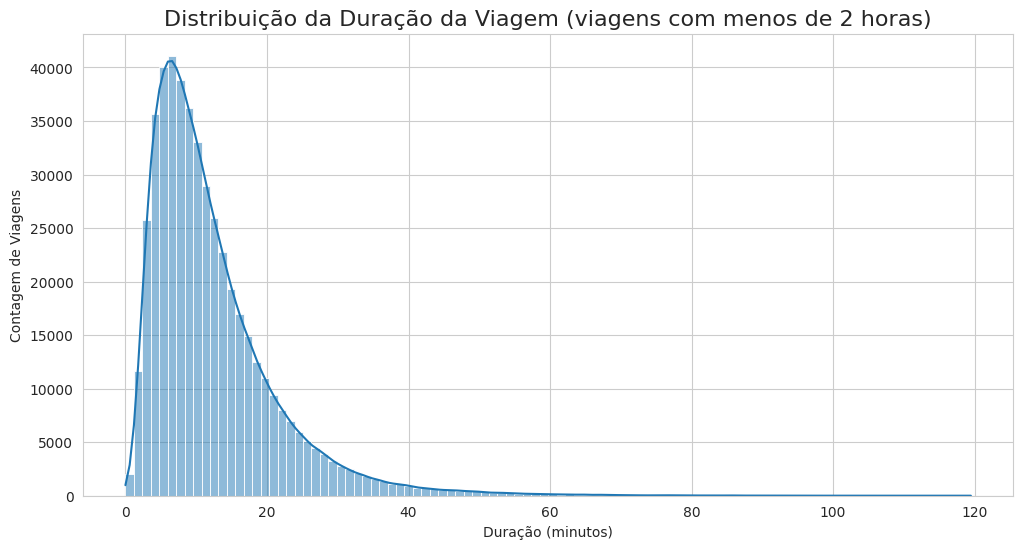

In [24]:
# Visualizando a distribuição da Duração da Viagem
plt.figure(figsize=(12, 6))

# Usar um limite no eixo x para melhor visualização
sns.histplot(df[df['trip_duration'] < 120]['trip_duration'], bins=100, kde=True)

plt.title('Distribuição da Duração da Viagem (viagens com menos de 2 horas)', fontsize=16)
plt.xlabel('Duração (minutos)')
plt.ylabel('Contagem de Viagens')
plt.show()

In [25]:
# ===== APLICAÇÃO DOS FILTROS DE PADRÕES SUSPEITOS =====

print("Iniciando a remoção final de padrões inconsistentes...")

# Guardar o número de registros antes da limpeza
rows_before = df.shape[0]
print(f"Registros antes da filtragem: {rows_before:,}")

# --- FILTRO 1: DURAÇÃO DA VIAGEM ---
# Manter apenas as viagens que duraram entre 1 minuto e 5 horas (300 minutos)
df = df[df['trip_duration'].between(1, 300)]

print(f"Registros após filtro de duração: {df.shape[0]:,}")

# --- FILTRO 2: ALTA DISTÂNCIA, BAIXO VALOR ---
# Identificar as linhas com o padrão suspeito
is_suspicious_price_dist = (df['trip_distance'] > 10) & (df['total_amount'] / df['trip_distance'] < 2)
# Manter apenas as linhas que NÃO (~) correspondem a este padrão
df = df[~is_suspicious_price_dist]

print(f"Registros após filtro de preço/distância: {df.shape[0]:,}")

# --- FILTRO 3: MESMA ZONA, ALTA DISTÂNCIA ---
# Identificar as linhas com o padrão suspeito
is_suspicious_zone_dist = (df['pickup_zone'] == df['dropoff_zone']) & (df['trip_distance'] > 10 )
# Manter apenas as linhas que NÃO (~) correspondem a este padrão
df = df[~is_suspicious_zone_dist]

print(f"Registros após filtro de zona/distância: {df.shape[0]:,}")

# --- SUMÁRIO DA OPERAÇÃO ---
rows_after = df.shape[0]
rows_removed = rows_before - rows_after
percentage_removed = (rows_removed / rows_before) * 100

print("\n" + "="*40)
print("      SUMÁRIO DA REMOÇÃO FINAL")
print("="*40)
print(f"Registros antes da filtragem:    {rows_before:,}")
print(f"Registros após a filtragem final: {rows_after:,}")
print(f"Total de registros removidos:      {rows_removed:,}")
print(f"Percentual de dados removidos:   {percentage_removed:.2f}%")
print("="*40)

Iniciando a remoção final de padrões inconsistentes...
Registros antes da filtragem: 486,798
Registros após filtro de duração: 485,206
Registros após filtro de preço/distância: 485,157
Registros após filtro de zona/distância: 483,569

      SUMÁRIO DA REMOÇÃO FINAL
Registros antes da filtragem:    486,798
Registros após a filtragem final: 483,569
Total de registros removidos:      3,229
Percentual de dados removidos:   0.66%


## 2.3 Análise de Padrões de Demanda

Visualizar os padrões de demanda com base nas features temporais e geoespaciais criadas.

- Ajuda a confirmar as hipóteses sobre a influência do tempo e da localização nas viagens de táxi. Esses gráficos fornecem insights valiosos que justificam a inclusão dessas features no modelo e ajudam a entender o comportamento do sistema de transporte urbano.

/tmp/ipython-input-1445277532.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pickup_hour", data=df, palette="viridis")


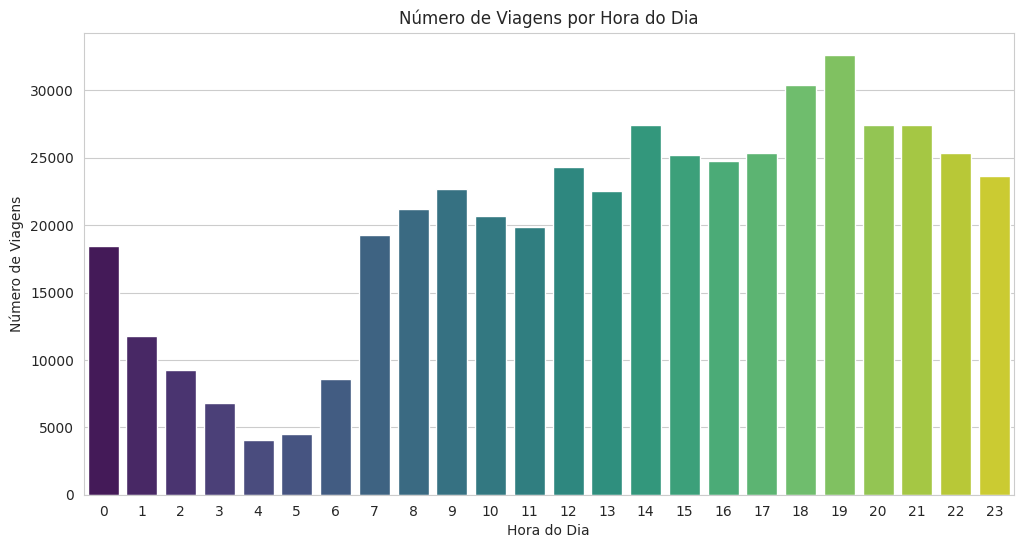

/tmp/ipython-input-1445277532.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pickup_day_of_week", data=df, palette="magma")


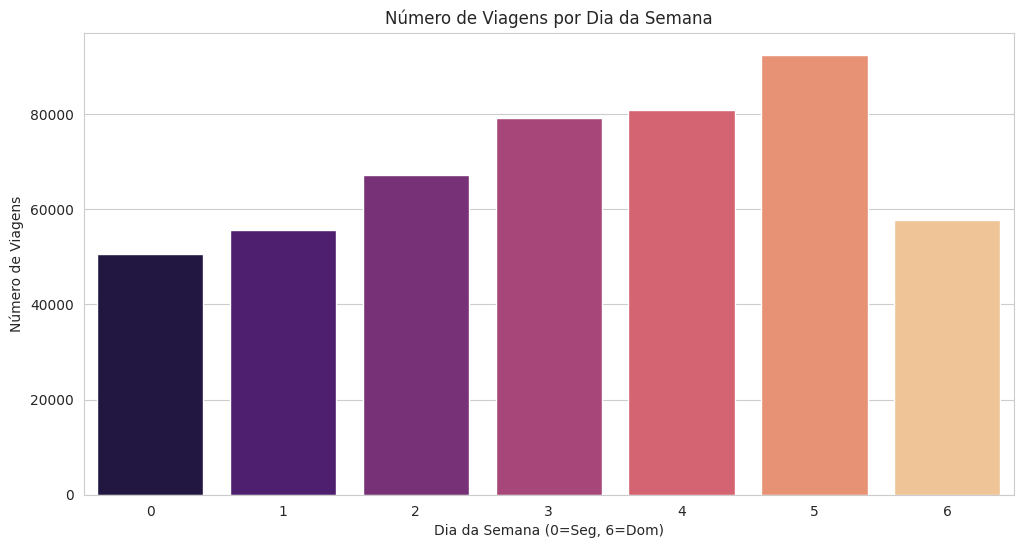

/tmp/ipython-input-1445277532.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="pickup_borough", data=df, order=df["pickup_borough"] .value_counts().index[:10], palette="plasma")


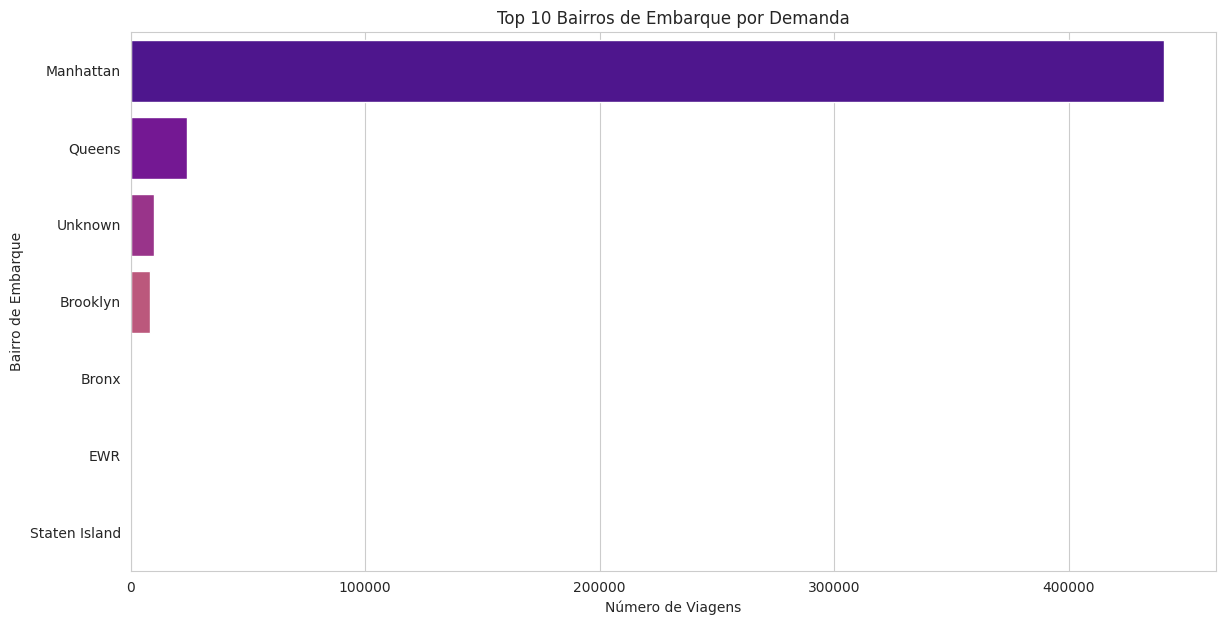

/tmp/ipython-input-1445277532.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="pickup_zone", data=df, order=df["pickup_zone"] .value_counts().index[:10], palette="cividis")


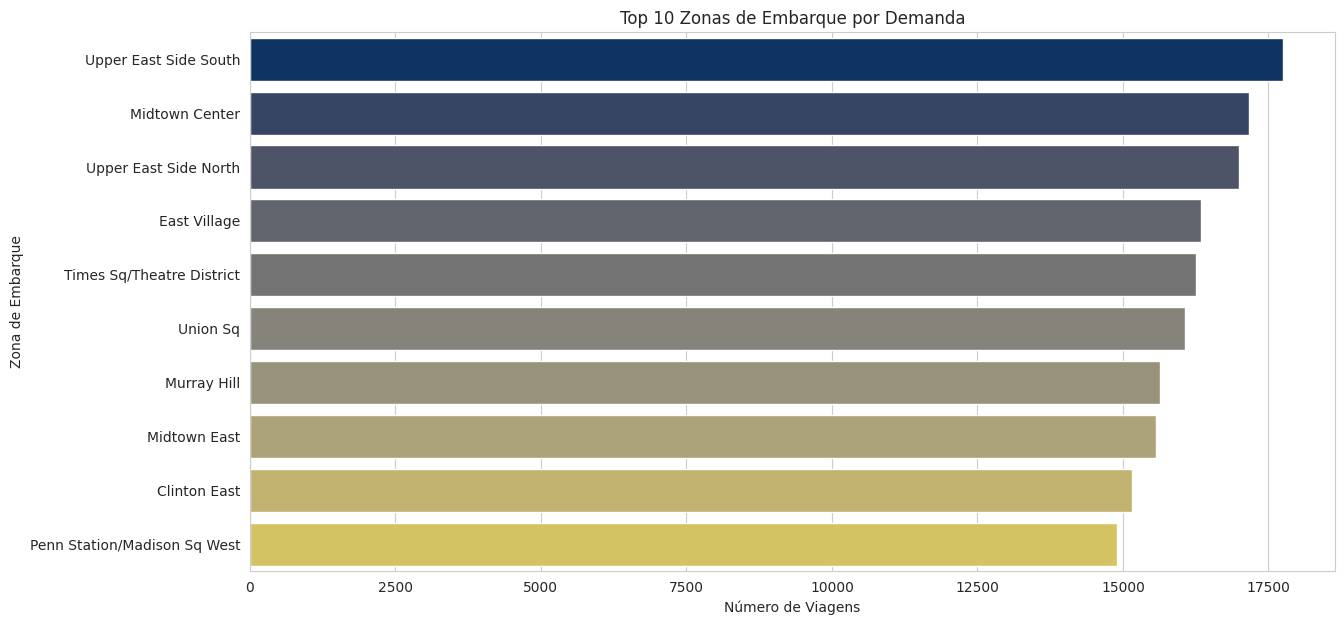

Análise de padrões de demanda concluída. Gráficos exibidos acima.


In [26]:
# Demanda por Hora do Dia
plt.figure(figsize=(12, 6))
sns.countplot(x="pickup_hour", data=df, palette="viridis")
plt.title("Número de Viagens por Hora do Dia")
plt.xlabel("Hora do Dia")
plt.ylabel("Número de Viagens")
plt.show()

# Demanda por Dia da Semana
plt.figure(figsize=(12, 6))
sns.countplot(x="pickup_day_of_week", data=df, palette="magma")
plt.title("Número de Viagens por Dia da Semana")
plt.xlabel("Dia da Semana (0=Seg, 6=Dom)")
plt.ylabel("Número de Viagens")
plt.show()

# Top 10 Bairros de Embarque por Demanda
plt.figure(figsize=(14, 7))
df["pickup_borough"] = df["pickup_borough"] # Garante que é uma coluna de string
sns.countplot(y="pickup_borough", data=df, order=df["pickup_borough"] .value_counts().index[:10], palette="plasma")
plt.title("Top 10 Bairros de Embarque por Demanda")
plt.xlabel("Número de Viagens")
plt.ylabel("Bairro de Embarque")
plt.show()

# Top 10 Zonas de Embarque por Demanda
plt.figure(figsize=(14, 7))
df["pickup_zone"] = df["pickup_zone"] # Garante que é uma coluna de string
sns.countplot(y="pickup_zone", data=df, order=df["pickup_zone"] .value_counts().index[:10], palette="cividis")
plt.title("Top 10 Zonas de Embarque por Demanda")
plt.xlabel("Número de Viagens")
plt.ylabel("Zona de Embarque")
plt.show()

print("Análise de padrões de demanda concluída. Gráficos exibidos acima.")

In [28]:
# ===== TESTE DE MULTICOLINEARIDADE (Redundância) =====
# Para garantir que nossas features numéricas não são redundantes entre si.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecionar features numéricas
numeric_features = ['trip_distance', 'passenger_count', 'pickup_hour', 'pickup_day_of_week', "trip_duration"]
X_vif = df[numeric_features].dropna()

print("TESTE DE MULTICOLINEARIDADE (VIF)")
for i, feature in enumerate(numeric_features):
    vif = variance_inflation_factor(X_vif.values, i)
    print(f"{feature}: VIF = {vif:.2f}")

print("INTERPRETAÇÃO:")
print("VIF < 5: Sem problema")
print("VIF 5-10: Multicolinearidade moderada")
print("VIF > 10: Multicolinearidade severa - remover variável")


TESTE DE MULTICOLINEARIDADE (VIF)
trip_distance: VIF = 4.37
passenger_count: VIF = 2.30
pickup_hour: VIF = 3.45
pickup_day_of_week: VIF = 2.93
trip_duration: VIF = 6.52
INTERPRETAÇÃO:
VIF < 5: Sem problema
VIF 5-10: Multicolinearidade moderada
VIF > 10: Multicolinearidade severa - remover variável


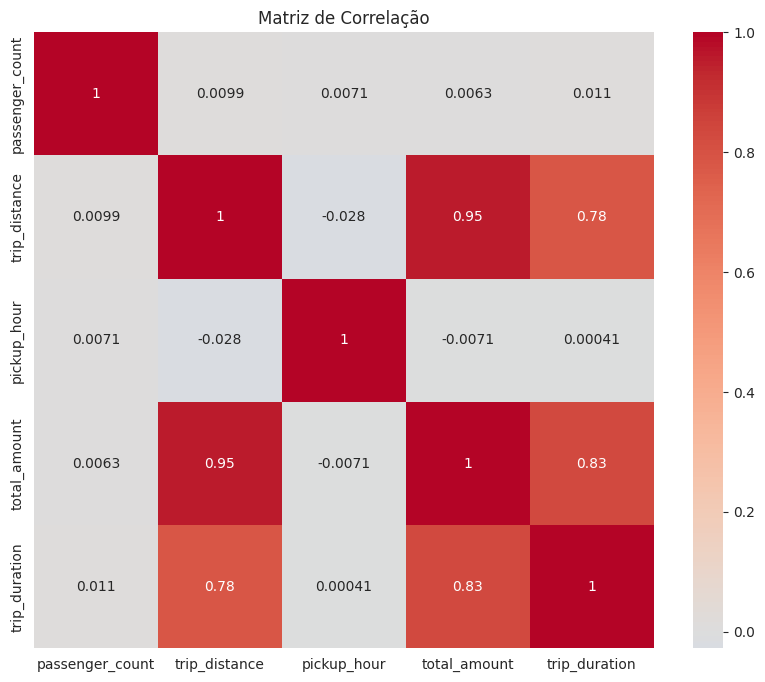

Outliers detectados no preço total: 39302 (8.13%)

Estatísticas por hora:
                  mean        std  count
pickup_hour                             
0            15.762994  11.015409  18445
1            15.117493   9.757428  11778
2            15.396380   9.865551   9223
3            15.600493  10.438386   6777
4            18.029517  14.046635   4041
5            19.352385  17.306696   4494
6            15.295275  14.693911   8611
7            14.110706  11.887195  19291
8            13.765324  10.570220  21183
9            13.702191  10.825404  22652
10           13.515026  10.498488  20642
11           13.683787  10.771391  19856
12           13.603574  10.911965  24340
13           13.874221  11.254640  22550
14           14.394953  12.408578  27409
15           14.652366  12.683089  25225
16           15.039274  12.571603  24779
17           14.668912  11.579378  25372
18           14.291582  10.420838  30365
19           14.086620   9.848435  32642
20           14.380630  

In [29]:
def detailed_eda(df):
    # Análise de correlação
    numerical_cols = ['passenger_count', 'trip_distance', 'pickup_hour', 'total_amount', "trip_duration"]
    correlation_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlação')
    plt.show()

    # Detecção de outliers
    Q1 = df['total_amount'].quantile(0.25)
    Q3 = df['total_amount'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['total_amount'] < Q1 - 1.5*IQR) | (df['total_amount'] > Q3 + 1.5*IQR)]

    print(f"Outliers detectados no preço total: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    # Análise temporal mais detalhada
    hourly_stats = df.groupby('pickup_hour')['total_amount'].agg(['mean', 'std', 'count'])
    print("\nEstatísticas por hora:")
    print(hourly_stats)

    return hourly_stats

# Chame a função:
eda_results = detailed_eda(df)


In [30]:
df["fare_amount"].describe()

,fare_amount
count,483569.00000
mean,11.67744
std,9.18131
min,0.00000
25%,6.50000
50%,9.00000
75%,13.50000
max,370.00000


---

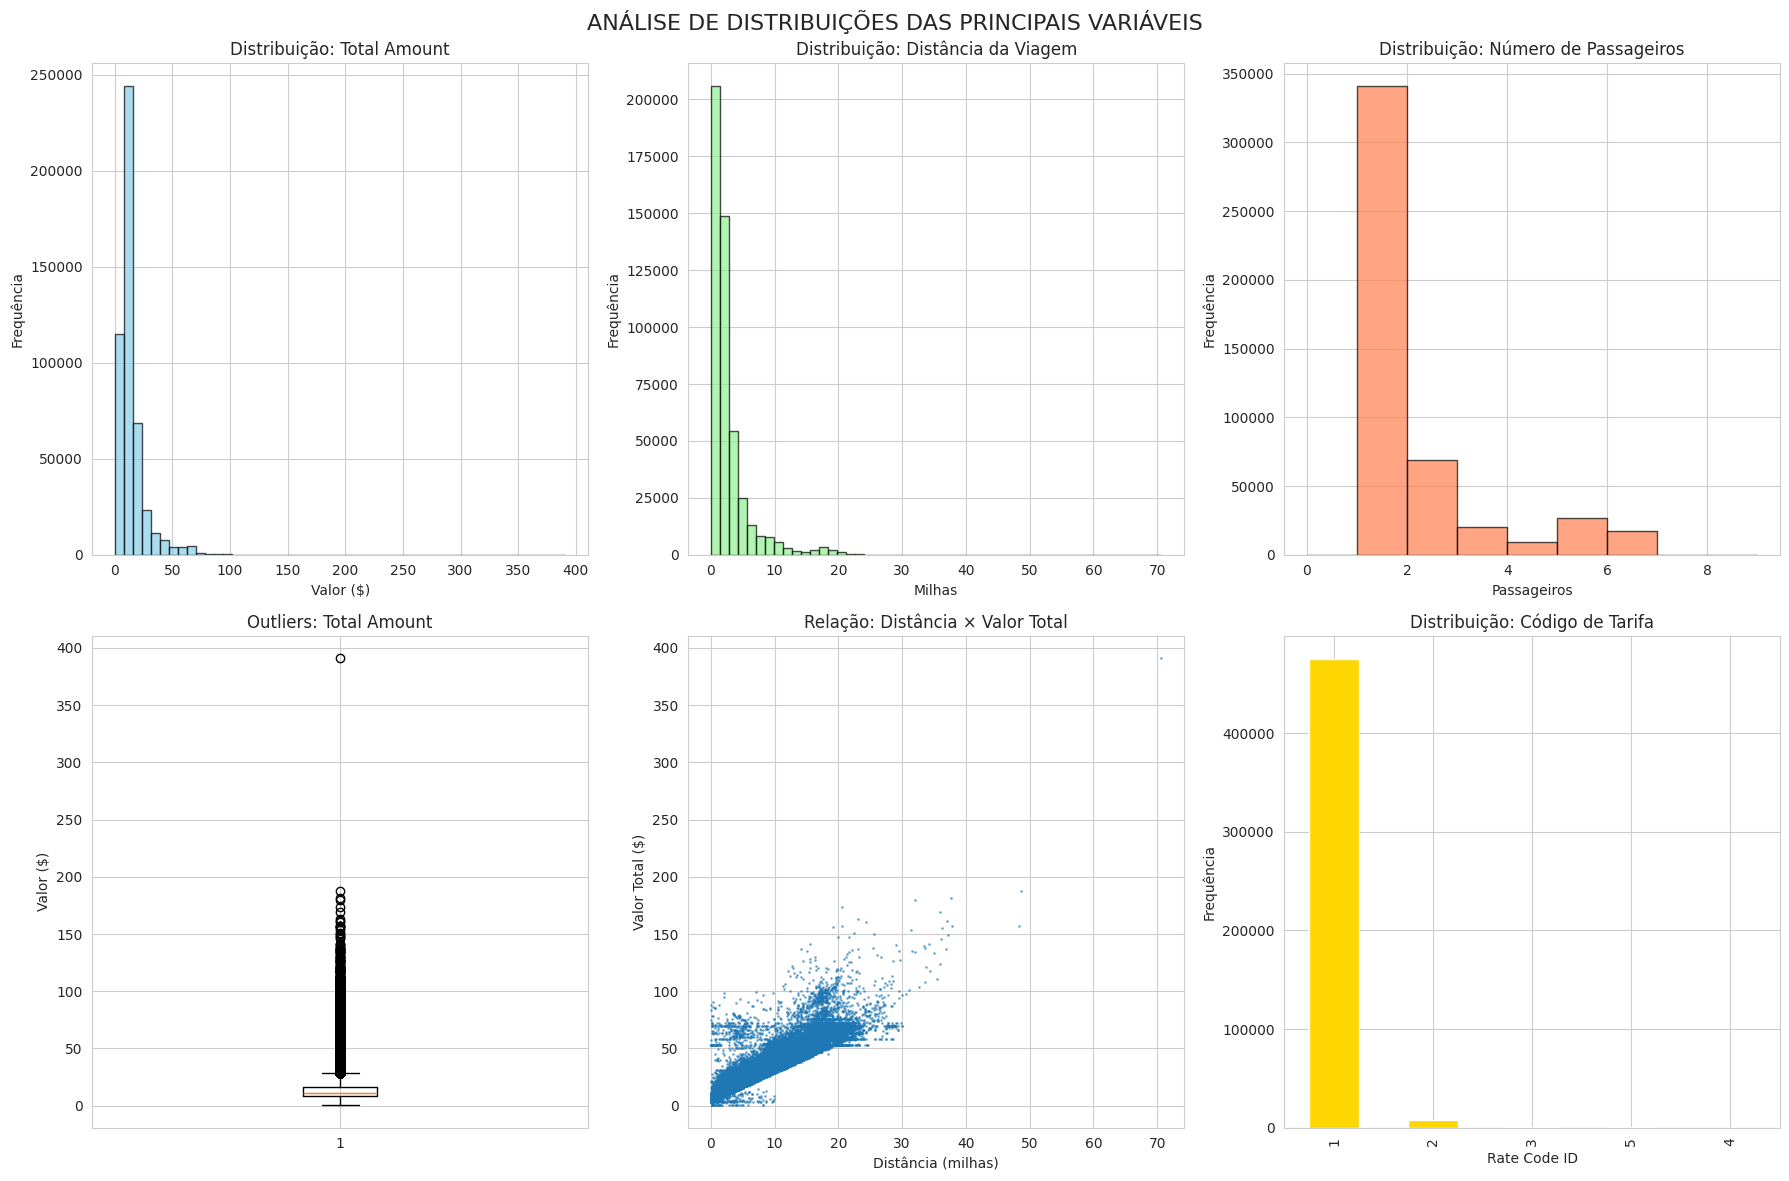

ANÁLISE DE OUTLIERS:
   Outliers detectados: 39302 (8.1%)
   Limite inferior: $-3.70
   Limite superior: $28.30


In [31]:
# ===== 2. ANÁLISE DE DISTRIBUIÇÕES =====
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ANÁLISE DE DISTRIBUIÇÕES DAS PRINCIPAIS VARIÁVEIS', fontsize=16)

# 2.1 Distribuição do total_amount (nossa variável alvo)
axes[0,0].hist(df['total_amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribuição: Total Amount')
axes[0,0].set_xlabel('Valor ($)')
axes[0,0].set_ylabel('Frequência')

# 2.2 Distribuição da distância
axes[0,1].hist(df['trip_distance'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribuição: Distância da Viagem')
axes[0,1].set_xlabel('Milhas')
axes[0,1].set_ylabel('Frequência')

# 2.3 Distribuição de passageiros
axes[0,2].hist(df['passenger_count'], bins=range(0, 10), alpha=0.7, color='coral', edgecolor='black')
axes[0,2].set_title('Distribuição: Número de Passageiros')
axes[0,2].set_xlabel('Passageiros')
axes[0,2].set_ylabel('Frequência')

# 2.4 Boxplot do total_amount para detectar outliers
axes[1,0].boxplot(df['total_amount'])
axes[1,0].set_title('Outliers: Total Amount')
axes[1,0].set_ylabel('Valor ($)')

# 2.5 Scatter: Distância vs Valor Total
axes[1,1].scatter(df['trip_distance'], df['total_amount'], alpha=0.5, s=1)
axes[1,1].set_title('Relação: Distância × Valor Total')
axes[1,1].set_xlabel('Distância (milhas)')
axes[1,1].set_ylabel('Valor Total ($)')

# 2.6 Distribuição por RateCodeID
df['RateCodeID'].value_counts().plot(kind='bar', ax=axes[1,2], color='gold')
axes[1,2].set_title('Distribuição: Código de Tarifa')
axes[1,2].set_xlabel('Rate Code ID')
axes[1,2].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

# Estatísticas de outliers
q1 = df['total_amount'].quantile(0.25)
q3 = df['total_amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['total_amount'] < lower_bound) | (df['total_amount'] > upper_bound)]
print(f"ANÁLISE DE OUTLIERS:")
print(f"   Outliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
print(f"   Limite inferior: ${lower_bound:.2f}")
print(f"   Limite superior: ${upper_bound:.2f}")


---

PADRÕES DE PREÇO POR HORA DO DIA:
             valor_medio
pickup_hour             
0                  15.76
1                  15.12
2                  15.40
3                  15.60
4                  18.03
5                  19.35
6                  15.30
7                  14.11
8                  13.77
9                  13.70
10                 13.52
11                 13.68
12                 13.60
13                 13.87
14                 14.39
15                 14.65
16                 15.04
17                 14.67
18                 14.29
19                 14.09
20                 14.38
21                 14.66
22                 15.17
23                 15.56


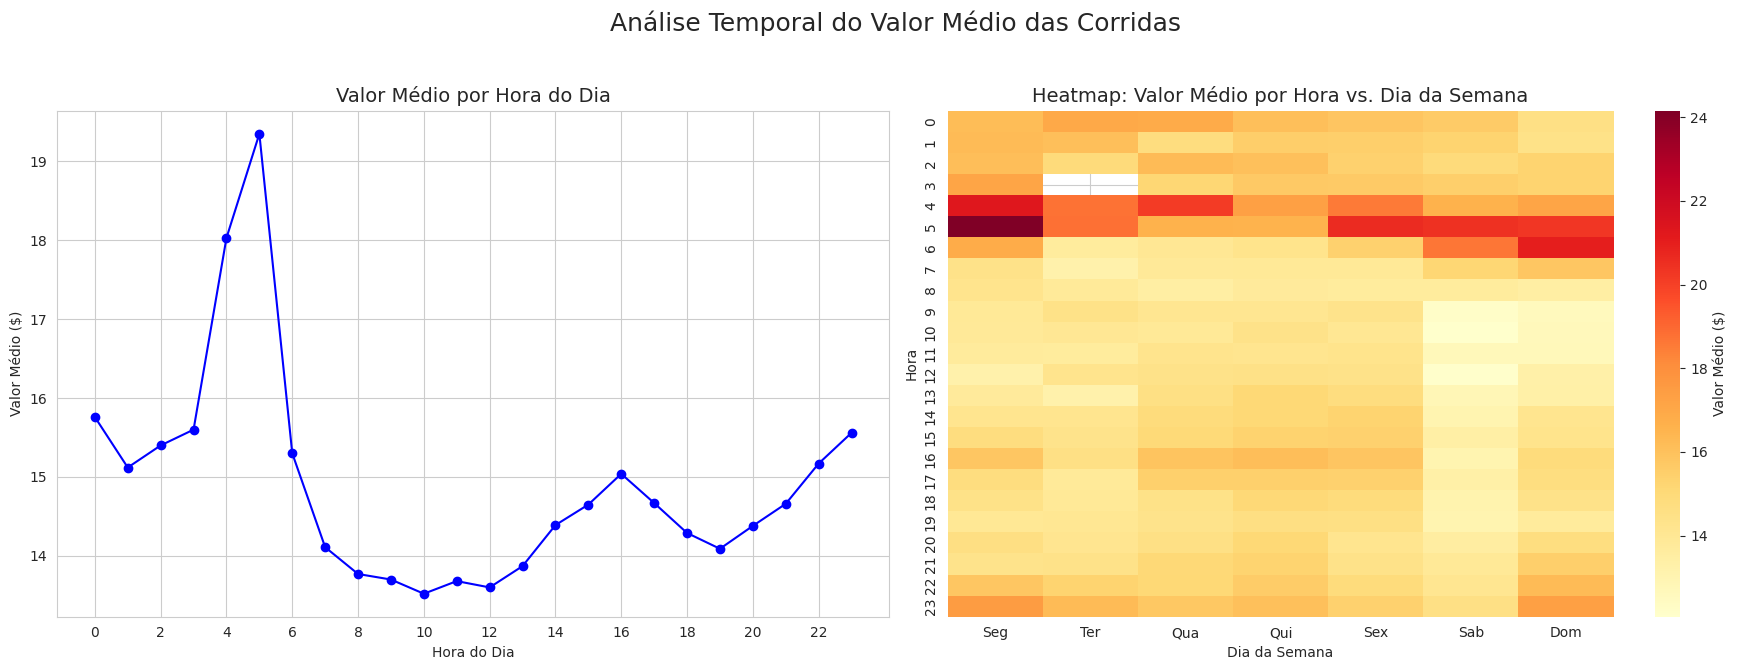

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===== PADRÕES TEMPORAIS DE PREÇO =====

# --- 1. Agregação de Dados ---
# Agrupar por hora para o gráfico de linha
hourly_stats = df.groupby('pickup_hour').agg(
    valor_medio=('total_amount', 'mean')
).round(2)

print("PADRÕES DE PREÇO POR HORA DO DIA:")
print(hourly_stats.head(24))

# --- 2. Visualização Focada em Preço ---
# Criar uma grade de 1 linha e 2 colunas para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Análise Temporal do Valor Médio das Corridas', fontsize=18)

# Gráfico 1: Valor médio por hora (Gráfico de Linha)
hourly_stats['valor_medio'].plot(kind='line', ax=axes[0], marker='o', color='blue')
axes[0].set_title('Valor Médio por Hora do Dia', fontsize=14)
axes[0].set_xlabel('Hora do Dia')
axes[0].set_ylabel('Valor Médio ($)')
axes[0].grid(True)
axes[0].set_xticks(range(0, 24, 2)) # Melhora a legibilidade do eixo x

# Gráfico 2: Heatmap Hora × Dia da Semana
# Preparar a tabela pivot para o heatmap
pivot_table = df.pivot_table(values='total_amount', index='pickup_hour', columns='pickup_day_of_week', aggfunc='mean')

# Mapear colunas para nomes dos dias para melhor leitura
day_map = {0: 'Seg', 1: 'Ter', 2: 'Qua', 3: 'Qui', 4: 'Sex', 5: 'Sab', 6: 'Dom'}
pivot_table.columns = pivot_table.columns.map(day_map)


sns.heatmap(pivot_table, ax=axes[1], cmap='YlOrRd', cbar_kws={'label': 'Valor Médio ($)'})
axes[1].set_title('Heatmap: Valor Médio por Hora vs. Dia da Semana', fontsize=14)
axes[1].set_xlabel('Dia da Semana')
axes[1].set_ylabel('Hora')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para o supertítulo
plt.show()

# 3. Pré-processamento dos Dados


In [33]:
# Definir features e target
# A variável alvo será 'total_amount'
# As features incluirão as novas colunas de zona/bairro e as features de tempo

# Remover colunas que não serão usadas como features ou que são redundantes
# Mantemos as colunas de data/hora para a amostragem, mas as removemos antes do treinamento do modelo
features_to_drop = [
    "tpep_pickup_datetime", "tpep_dropoff_datetime", "VendorID", "store_and_fwd_flag",
    "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
    "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge"
]

# Garantir que as colunas existem antes de tentar removê-las
existing_features_to_drop = [col for col in features_to_drop if col in df.columns]
X = df.drop(columns=existing_features_to_drop + ["total_amount"])
y = df["total_amount"]

numerical_features = [
    "passenger_count",
    "trip_distance",
    "pickup_hour",
    "pickup_day_of_week",
    "pickup_month",
    "trip_duration"
]
categorical_features = [
    "payment_type",
    "pickup_zone",
    "pickup_borough",
    "dropoff_zone",
    "dropoff_borough",
    "RateCodeID"
]

# Criar o pré-processador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar o pré-processamento nos dados de treino e teste
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Dados preparados para o modelo de rede neural.")
print(f"Shape de X_train_processed: {X_train_processed.shape}")
print(f"Shape de X_test_processed: {X_test_processed.shape}")

# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train_processed.toarray(), dtype=torch.float32) # .toarray() para sparse matrix
X_test_tensor = torch.tensor(X_test_processed.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

print("Dados convertidos para tensores PyTorch.")
print(f"Shape de X_train_tensor: {X_train_tensor.shape}")
print(f"Shape de y_train_tensor: {y_train_tensor.shape}")

Dados preparados para o modelo de rede neural.
Shape de X_train_processed: (386855, 509)
Shape de X_test_processed: (96714, 509)
Dados convertidos para tensores PyTorch.
Shape de X_train_tensor: torch.Size([386855, 509])
Shape de y_train_tensor: torch.Size([386855, 1])


A transformação para tensores serve para converter os dados no formato especializado que possibilita a aceleração massiva dos cálculos em uma GPU e permite que a rede neural aprenda através da diferenciação automática.

# 4. Desenvolvimento do Modelo de Rede Neural

- Utilizei RELU para introduzir a não linearidade no modelo de forma rápida e eficaz

In [34]:
# Definir a arquitetura da rede neural
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1) # Saída para regressão (valor único)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Instanciar o modelo
input_size = X_train_tensor.shape[1]
model = RegressionNN(input_size)

# Definir função de perda e otimizador
criterion = nn.MSELoss() # Mean Squared Error para regressão
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Arquitetura da Rede Neural definida:")
print(model)

Arquitetura da Rede Neural definida:
RegressionNN(
  (fc1): Linear(in_features=509, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


- A MSELoss, ao elevar os erros ao quadrado, ela penaliza fortemente as previsões muito erradas, forçando o modelo a aprender a evitar outliers e a ser mais preciso nos casos mais difíceis.
- O otimizador Adam ajusta a taxa de aprendizado de forma inteligente e automática para cada peso da rede, resultando em um treinamento mais rápido, estável e eficiente.

## 4.2 Treinamento do Modelo

- O modelo será treinado utilizando os dados pré-processados. Devido a possíveis limitações de memória, o número de épocas e o tamanho do batch foram ajustados para permitir a execução no ambiente.

- O uso de batches ajuda a otimizar o uso de memória e a estabilizar o processo de treinamento, enquanto o número de épocas determina quantas vezes o modelo verá o dataset completo.
- Utilizei o treinamento em batch de tamanho 512. Em cada passo, o modelo faz previsões para um lote, calcula o erro (loss) usando a MSELoss, e ajusta seus pesos através do algoritmo de backpropagation e do otimizador Adam. Foi uma decisão para otimizar o processo, estabelecendo um equilíbrio entre a eficiência computacional para o paralelismo na GPU, a estabilidade na estimativa do gradiente para uma convergência robusta, e a viabilidade do treinamento dentro das limitações de memória.

In [35]:
# Treinamento do modelo com batch
num_epochs = 50
batch_size = 512

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Salvar o modelo treinado
torch.save(model.state_dict(), "regression_nn_model.pth")
print("Modelo treinado e salvo em regression_nn_model.pth")

Epoch [1/50], Loss: 3.2950
Epoch [2/50], Loss: 2.7736
Epoch [3/50], Loss: 2.5145
Epoch [4/50], Loss: 2.4075
Epoch [5/50], Loss: 2.3860
Epoch [6/50], Loss: 2.3278
Epoch [7/50], Loss: 2.3125
Epoch [8/50], Loss: 2.2540
Epoch [9/50], Loss: 2.2007
Epoch [10/50], Loss: 2.1622
Epoch [11/50], Loss: 2.1382
Epoch [12/50], Loss: 2.1208
Epoch [13/50], Loss: 2.1035
Epoch [14/50], Loss: 2.0732
Epoch [15/50], Loss: 2.0597
Epoch [16/50], Loss: 2.0516
Epoch [17/50], Loss: 2.0178
Epoch [18/50], Loss: 2.0094
Epoch [19/50], Loss: 1.9308
Epoch [20/50], Loss: 1.9167
Epoch [21/50], Loss: 1.9198
Epoch [22/50], Loss: 1.8839
Epoch [23/50], Loss: 1.8802
Epoch [24/50], Loss: 1.8775
Epoch [25/50], Loss: 1.8631
Epoch [26/50], Loss: 1.8565
Epoch [27/50], Loss: 1.8443
Epoch [28/50], Loss: 1.8107
Epoch [29/50], Loss: 1.8021
Epoch [30/50], Loss: 1.8070
Epoch [31/50], Loss: 1.7948
Epoch [32/50], Loss: 1.7774
Epoch [33/50], Loss: 1.7711
Epoch [34/50], Loss: 1.7452
Epoch [35/50], Loss: 1.7567
Epoch [36/50], Loss: 1.7274
E

# 5. Avaliação e Análise dos Resultados

Nesta seção, avaliaremos o desempenho do modelo treinado no conjunto de teste e analisaremos os resultados.

In [37]:
# Carregar o modelo treinado com batch
input_size = X_test_tensor.shape[1]
model = RegressionNN(input_size)
model.load_state_dict(torch.load("regression_nn_model.pth"))
model.eval() # Colocar o modelo em modo de avaliação

# Fazer previsões no conjunto de teste
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.numpy()

# Calcular métricas de regressão
mse = mean_squared_error(y_test_tensor.numpy(), y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_tensor.numpy(), y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Análise simples das previsões
print("\nEstatísticas das Previsões:")
print(f"Média das previsões: {np.mean(y_pred):.4f}")
print(f"Desvio padrão das previsões: {np.std(y_pred):.4f}")
print(f"Mínimo das previsões: {np.min(y_pred):.4f}")
print(f"Máximo das previsões: {np.max(y_pred):.4f}")

print("\nEstatísticas dos Valores Reais:")
print(f"Média dos valores reais: {np.mean(y_test_tensor.numpy()):.4f}")
print(f"Desvio padrão dos valores reais: {np.std(y_test_tensor.numpy()):.4f}")
print(f"Mínimo dos valores reais: {np.min(y_test_tensor.numpy()):.4f}")
print(f"Máximo dos valores reais: {np.max(y_test_tensor.numpy()):.4f}")


Mean Squared Error (MSE): 3.4445
Root Mean Squared Error (RMSE): 1.8559
R-squared (R2): 0.9729

Estatísticas das Previsões:
Média das previsões: 14.6772
Desvio padrão das previsões: 11.3416
Mínimo das previsões: -2.2039
Máximo das previsões: 170.3309

Estatísticas dos Valores Reais:
Média dos valores reais: 14.5664
Desvio padrão dos valores reais: 11.2730
Mínimo dos valores reais: 0.3000
Máximo dos valores reais: 181.0500


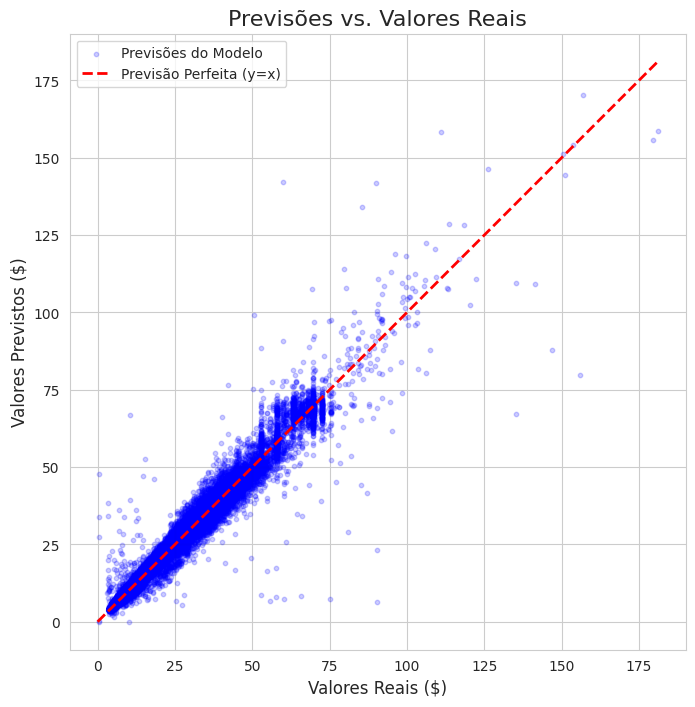

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# ===== VISUALIZAÇÃO FOCADA: PREVISÕES VS. VALORES REAIS =====

# Assumindo que 'y_test_real' e 'y_pred' já existem
# y_test_real = y_test_tensor.numpy()
# y_pred = y_pred_tensor.numpy()
# y_pred[y_pred < 0] = 0 # Lembre-se de tratar os negativos

# Criar a figura e um único eixo para o gráfico
fig, ax = plt.subplots(figsize=(8, 8))

# 1. Plotar os pontos de dispersão
ax.scatter(y_test_real, y_pred, alpha=0.2, s=10, color='blue', label='Previsões do Modelo')

# 2. Plotar a linha de referência (Previsão Perfeita)
# Para uma comparação justa, a linha deve ir do mínimo ao máximo dos dados
lims = [
    min(y_test_real.min(), y_pred.min()),
    max(y_test_real.max(), y_pred.max()),
]
ax.plot(lims, lims, '--', color='red', lw=2, label='Previsão Perfeita (y=x)')

# 3. Adicionar títulos e labels
ax.set_title('Previsões vs. Valores Reais', fontsize=16)
ax.set_xlabel('Valores Reais ($)', fontsize=12)
ax.set_ylabel('Valores Previstos ($)', fontsize=12)
ax.legend()
ax.grid(True)

# 4. (Opcional, mas recomendado) Forçar a mesma escala nos eixos X e Y
# Isso garante que a linha de 45 graus seja visualmente precisa
ax.set_aspect('equal', adjustable='box')

plt.show()